<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NHL-predictions-project---Data-Interpretation" data-toc-modified-id="NHL-predictions-project---Data-Interpretation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NHL predictions project - Data Interpretation</a></span></li><li><span><a href="#Preparation" data-toc-modified-id="Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#General-Data-Analytics" data-toc-modified-id="General-Data-Analytics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General Data Analytics</a></span></li><li><span><a href="#Game-result-estimation" data-toc-modified-id="Game-result-estimation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Game result estimation</a></span><ul class="toc-item"><li><span><a href="#Variable-names-and-meanings" data-toc-modified-id="Variable-names-and-meanings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Variable names and meanings</a></span></li><li><span><a href="#Data-Analytics-about-the-two-teams" data-toc-modified-id="Data-Analytics-about-the-two-teams-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Data Analytics about the two teams</a></span></li><li><span><a href="#Model-1---based-on-matches-between-2-teams" data-toc-modified-id="Model-1---based-on-matches-between-2-teams-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Model 1 - based on matches between 2 teams</a></span></li><li><span><a href="#Model-2---Logistic-Regression" data-toc-modified-id="Model-2---Logistic-Regression-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Model 2 - Logistic Regression</a></span></li><li><span><a href="#Model-3---Neural-Network" data-toc-modified-id="Model-3---Neural-Network-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Model 3 - Neural Network</a></span></li><li><span><a href="#Comparison-of-the-3-models-and-their-performance" data-toc-modified-id="Comparison-of-the-3-models-and-their-performance-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Comparison of the 3 models and their performance</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# NHL predictions project - Data Interpretation

This is project for the subject Data Processing in Python - JEM207. That was created by Pavlína Křenková and Vojtěch Vaverka.

The code we wrote scrapes data from the website https://nhl.cz/. After the data is scraped, user of the code needs to fill in names of two teams into the variables team_1 and team_2. Once those two variables are set the code creates a Logistic regression that predicts which team is going to win. Druing our testing of the code we have reached accuracy above 50%. That means that the model is better than randomly guessing. Yet it should not be used to place bets.

First, we will prepare the data. Then, we will perform several analysis to familiarize even the non-hockey-fans with the teams and their recent performence. Finally we estimate 3 models to predict an outcome of the game. This prediction can be used for entertainment or casual betting; however, the authors do not take any responsibility if a user decides to do so.

# Preparation

### Importing the packages 

* *pandas* - loading and working with the DataFrames
* *numpy* - working with matrices when building the logistic regression
* *matplotlib* - used for data visualization
* *sklearn* - used to build the logistic regression
* *seaborn* - used for data visualization
* *statistics* - to compute the averages
* *ipywidgets* - for dropdown menus to choose which teams to analyze
* *tensorflow* - to build the neural network
* *keras* - to build the neural network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean
from ipywidgets import Dropdown
import itertools
import seaborn as sns

#logistic reg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model

We load the necessary information about the teams, which we will later use for file loading and analysis

In [2]:
teams_info = pd.read_csv('teams_info/teams_info.csv')
all_matches = pd.read_csv('all_matches.csv')

# We will be analysing the 5 most recent seasons
seasons_used = ['2017', '2018', '2019', '2020','2021'] # 2017 is the 2017/2018 season, etc.

distinct_teams = teams_info['team'].tolist() # the list of all teams

#each team has its short name that was used to name the files that contain data
teams_dict = pd.Series(teams_info.team_short.values,index=teams_info.team).to_dict()
teams_dict

{'Anaheim Ducks': 'ANA',
 'Arizona Coyotes': 'ARI',
 'Boston Bruins': 'BOS',
 'Buffalo Sabres': 'BUF',
 'Calgary Flames': 'CGY',
 'Carolina Hurricanes': 'CAR',
 'Chicago Blackhawks': 'CHI',
 'Colorado Avalanche': 'COL',
 'Columbus Blue Jackets': 'CBJ',
 'Dallas Stars': 'DAL',
 'Detroit Red Wings': 'DET',
 'Edmonton Oilers': 'EDM',
 'Florida Panthers': 'FLA',
 'Los Angeles Kings': 'LAK',
 'Minnesota Wild': 'MIN',
 'Montreal Canadiens': 'MTL',
 'Nashville Predators': 'NSH',
 'New Jersey Devils': 'NJD',
 'New York Islanders': 'NYI',
 'New York Rangers': 'NYR',
 'Ottawa Senators': 'OTT',
 'Philadelphia Flyers': 'PHI',
 'Pittsburgh Penguins': 'PIT',
 'San Jose Sharks': 'SJS',
 'Seattle Kraken': 'SEA',
 'St. Louis Blues': 'STL',
 'Tampa Bay Lightning': 'TBL',
 'Toronto Maple Leafs': 'TOR',
 'Vancouver Canucks': 'VAN',
 'Vegas Golden Knights': 'VGK',
 'Washington Capitals': 'WSH',
 'Winnipeg Jets': 'WPG'}

In [3]:
all_dfs_pre = []
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_pre-processed/{one_team_short}_pre.csv')
    all_dfs_pre.append(matches_one_team)
all_dfs_pre[1].head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season
0,/zapas/2526065,Anaheim Ducks,Arizona Coyotes,5,4,0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,Anaheim Ducks,Arizona Coyotes,2017
1,/zapas/2526080,Arizona Coyotes,Vegas Golden Knights,1,2,1,1.0,2.0,1.0,1.0,1.0,2.0,0.0,Vegas Golden Knights,Arizona Coyotes,2017
2,/zapas/2526099,Vegas Golden Knights,Arizona Coyotes,5,2,0,3.0,0.0,0.0,0.0,2.0,5.0,0.0,Vegas Golden Knights,Arizona Coyotes,2017
3,/zapas/2526110,Arizona Coyotes,Detroit Red Wings,2,4,0,0.0,3.0,1.0,0.0,2.0,4.0,0.0,Detroit Red Wings,Arizona Coyotes,2017
4,/zapas/2526126,Arizona Coyotes,Boston Bruins,2,6,0,0.0,3.0,1.0,0.0,2.0,6.0,0.0,Boston Bruins,Arizona Coyotes,2017


# General Data Analytics
<a id='General_da'></a>

In this section we will analyze the data and provide some interesting insights.

### Home advantage

### For each team over all seasons

We first checked if the ratio of home games to away games was approximately 1:1 for each team (the list *ratio_of_home_games*). So that we could use the following calculation for home advantage without it favoring teams that played the majority of games at home.

$ \text{Home advantage} = \frac{\text{Games Won at Home}}{\text{Games Won Home and Away}} $

In [4]:
ratio_of_home_games = []
for one_df in all_dfs_pre:
    hg = (sum((one_df['TOI_home'] == 1)))/len(one_df['TOI_home'] == 1)
    ratio_of_home_games.append(hg) 
print(ratio_of_home_games)#the home:away ratios are very balanced 

[0.5013404825737265, 0.4946236559139785, 0.5, 0.5013477088948787, 0.4946236559139785, 0.4972972972972973, 0.49731182795698925, 0.4946236559139785, 0.5026881720430108, 0.49865229110512127, 0.5040214477211796, 0.4959785522788204, 0.5013477088948787, 0.49731182795698925, 0.5013477088948787, 0.5040214477211796, 0.5013477088948787, 0.49865229110512127, 0.5027027027027027, 0.5026881720430108, 0.5040214477211796, 0.5013477088948787, 0.5013477088948787, 0.5026881720430108, 0.5, 0.49865951742627346, 0.49731182795698925, 0.49731182795698925, 0.5013477088948787, 0.5040214477211796, 0.49595687331536387, 0.5040214477211796]


In [5]:
home_advantages = {}
for x in range(len(distinct_teams)):
    one_team = distinct_teams[x]
    matches_one_team = all_dfs_pre[x]
    home_ad = (sum((matches_one_team['TOI_home'] == 1) & (matches_one_team['TOI_result'] == 1)))/sum(matches_one_team['TOI_result'] == 1)
    home_advantages[one_team] = home_ad
home_advantages = sorted(home_advantages.items(), key=lambda x: x[1], reverse = True)
home_advantages = pd.DataFrame(home_advantages, columns=['team', 'home_advantage'])
home_advantages

,team,home_advantage
0,Seattle Kraken,0.592593
1,Ottawa Senators,0.586957
2,Detroit Red Wings,0.576923
3,Dallas Stars,0.570681
4,Buffalo Sabres,0.570370
5,Pittsburgh Penguins,0.565421
6,Florida Panthers,0.561905
7,New York Islanders,0.556150
8,Minnesota Wild,0.556098
9,Columbus Blue Jackets,0.555556


In [6]:
home_advantages.loc[home_advantages['home_advantage'] < 0.5]

,team,home_advantage
30,Calgary Flames,0.497487
31,Washington Capitals,0.486239


There seems to be at least a slight home advantage for all teams except Calgary Flames and Washington Capitals.

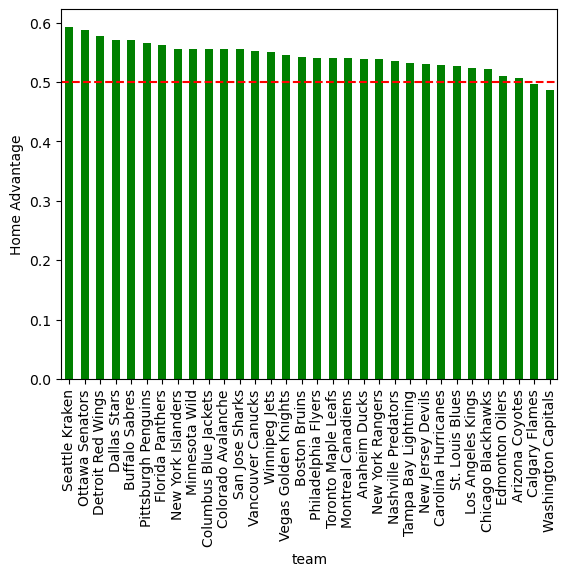

In [7]:
ha = home_advantages.plot(x = 'team', legend=False, kind = 'bar', color = 'green')
plt.ylabel('Home Advantage')
plt.axhline(y= 0.5,color='red', linestyle ='dashed')
plt.xticks(rotation='vertical')
plt.show()

### Home advantage for individual seasons over all teams

In [8]:
home_advantage = pd.DataFrame(seasons_used, columns=['year'])
ha = []
for season in seasons_used:
    ha_one_season = sum(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])/len(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])
    ha.append(round(ha_one_season*100,3))
home_advantage["win_home_percentage"] = ha
home_advantage

,year,win_home_percentage
0,2017,56.334
1,2018,53.659
2,2019,53.327
3,2020,53.341
4,2021,53.659


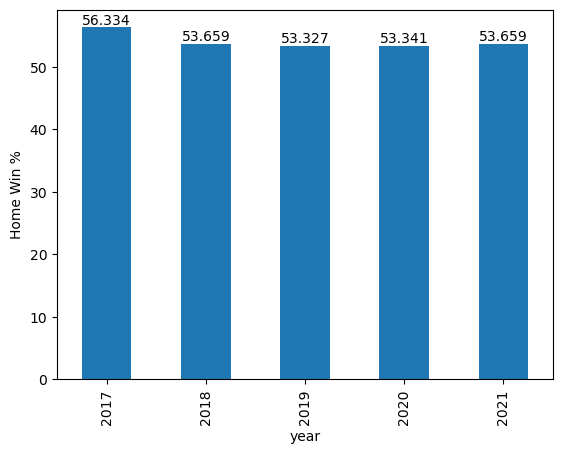

In [9]:
ha = home_advantage.plot(x = 'year', legend=False, kind = "bar")
plt.ylabel("Home Win %")
ha.bar_label(ha.containers[0], labels=home_advantage['win_home_percentage'])
plt.show()

The home advantage seems to be pretty stable over time. 

### Home advantage for all teams and all seasons

In [10]:
sum(all_matches["home_wins"])/len(all_matches["home_wins"])

0.5413507925568574

54% of games are won by the home team.

# Game result estimation

In this section we analyze the data of the two teams that the reader chooses, and then we implement 3 models to predict an outcome of the game of those two teams. At the end of the section there is a summary of the methods used and our recommendation based on the performance of those methods.

### Choosing two teams

Below are 2 dropdown widgets. Please choose the two teams of your interest.

In [11]:
# ipywidgets do not show on github - run the notebook in order to see them
teams_info = pd.read_csv('teams_info/teams_info.csv')
option_list = teams_info['team'].tolist()
option_list.insert(0, '')
team_1_drop = ''
team_2_drop = ''
drop_down_team_1 = Dropdown(options=option_list,description='Choose the home team (Team 1):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
drop_down_team_2 = Dropdown(options=option_list,description='Choose the away team (Team 2):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
def dropdown_handler_team_1(choice):
    global team_1_drop
    print("Team 1:", choice.new)
    team_1_drop = choice.new
def dropdown_handler_team_2(choice):
    global team_2_drop
    print("Team 2:", choice.new)
    team_2_drop = choice.new
drop_down_team_1.observe(dropdown_handler_team_1, names='value')
drop_down_team_2.observe(dropdown_handler_team_2, names='value')
display(drop_down_team_1, drop_down_team_2)

Dropdown(description='Choose the home team (Team 1):', layout=Layout(width='max-content'), options=('', 'Anahe…

Dropdown(description='Choose the away team (Team 2):', layout=Layout(width='max-content'), options=('', 'Anahe…

Now we check whether the choice was made.

In [12]:
if team_1_drop == "" or team_2_drop == "":  
    print("You have not chosen both teams yet, please return to previous cell and do so. \n"
    "If both teams are not chosen, the game between Boston Bruins and Tampa Bay Lightning will be predicted.")
    
    # A base arbitrary choice was made, so that all cells can be run at once.
    team_1 = "Boston Bruins"
    team_2 = "Tampa Bay Lightning"
    
    
elif team_1_drop == team_2_drop:
    
    print("You picked the same team twice, please return to previous cell and change at least one team. \n"
         'Otherwise the other team will be picked for you.')
    # A base arbitrary choice was made, so that analysis can continue if user does not specify..
    # ..teams correctly
    team_1 = team_1_drop
    if team_1 == "Boston Bruins":
        team_2 = "Tampa Bay Lightning"
    else:
        team_2 = "Boston Bruins"
    
else:
    team_1 = team_1_drop
    team_2 = team_2_drop

You have not chosen both teams yet, please return to previous cell and do so. 
If both teams are not chosen, the game between Boston Bruins and Tampa Bay Lightning will be predicted.


In [13]:
print("The outcome of the match", team_1, "vs", team_2, "will be predicted.")

The outcome of the match Boston Bruins vs Tampa Bay Lightning will be predicted.


We obtain the short names of the teams and load the file with the processed data, that was created by *scraping.py* and *processing.py*

In [14]:
team_1_short = teams_dict[team_1]
team_2_short = teams_dict[team_2]

## Variable names and meanings
<a id='variables'></a>

Variable names mean the following:
* *game_id* - unique game ID
* *TOI_result* - did Team of Interest (from now *TOI*, the team to which this dataframe belongs) win ( = 1) or loose ( = 0)
* *TOI_home* - did TOI play home ( = 1) or away ( = 0)
* *other_team* - who was the other team in the game
* *TOI_points_tot* - how many points did TOI gain in the last 20 games
* *TOI_goals_scored_tot* - how many goals did TOI score in the last 20 games
* *TOI_goals_rec_tot* - how many goals did TOI receive in the last 20 games
* *other_team_points_tot* - how many points did the other team gain in the last 20 games
* *other_team_goals_scored_tot* - how many goals did the other team score in the last 20 games
* *other_team_goals_rec_tot* - how many goals did the other team receive in the last 20 games

## Data Analytics about the two teams
<a id='2team_da'></a>

In this section we analyze the two teams so that the user can have an idea about them. For example how good they generally are or how do their results change over time

### After picking 2 teams both their final_dfs are found, saved and displayed

In [15]:
matches_team_1s = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_team_2s = pd.read_csv(f'teams_final/{team_2_short}.csv')
matches_between_them = matches_team_1s.merge(matches_team_2s, left_on='game_id', right_on='game_id',suffixes=('', '2'))
matches_between_them.drop(columns=['TOI_result2', 'TOI_home2','TOI2','other_team2','TOI_points_tot2','TOI_goals_scored_tot2','TOI_goals_rec_tot2'], inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
matches_between_them.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot,other_team_points_tot2,other_team_goals_scored_tot2,other_team_goals_rec_tot2
0,/zapas/2526431,1.0,1.0,Boston Bruins,Tampa Bay Lightning,30.0,56.0,59.0,42.0,70.0,47.0,30.0,56.0,59.0
1,/zapas/2527156,1.0,0.0,Boston Bruins,Tampa Bay Lightning,38.0,72.0,59.0,37.0,81.0,70.0,38.0,72.0,59.0
2,/zapas/2527244,1.0,1.0,Boston Bruins,Tampa Bay Lightning,34.0,64.0,61.0,34.0,72.0,68.0,34.0,64.0,61.0
3,/zapas/2527287,0.0,0.0,Boston Bruins,Tampa Bay Lightning,36.0,70.0,59.0,34.0,72.0,69.0,36.0,70.0,59.0
4,/zapas/2647632,0.0,0.0,Boston Bruins,Tampa Bay Lightning,30.0,45.0,48.0,38.0,82.0,65.0,30.0,45.0,48.0


#### We create data frames for graphs and we add the variable match_ordr that displays the order of matches of a given team

In [16]:
matches_team_1_graphs = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_graphs = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')
matches_team_1_graphs['match_ordr'] = range(1, len(matches_team_1_graphs) + 1)
matches_team_2_graphs['match_ordr'] = range(1, len(matches_team_2_graphs) + 1)
matches_team_2_graphs.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
0,/zapas/2526068,Tampa Bay Lightning,Florida Panthers,5,3,0,3.0,0.0,1.0,3.0,5.0,3.0,1.0,Florida Panthers,Tampa Bay Lightning,2017,1
1,/zapas/2526073,Florida Panthers,Tampa Bay Lightning,5,4,0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,Florida Panthers,Tampa Bay Lightning,2017,2
2,/zapas/2526090,Tampa Bay Lightning,Washington Capitals,4,3,1,2.0,1.0,1.0,2.0,4.0,3.0,1.0,Washington Capitals,Tampa Bay Lightning,2017,3
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,0.0,1.0,3.0,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,4
4,/zapas/2526122,Tampa Bay Lightning,St. Louis Blues,2,1,0,3.0,0.0,1.0,3.0,2.0,1.0,1.0,St. Louis Blues,Tampa Bay Lightning,2017,5


### Merge both teams into one dataframe and create a graph of scored goals

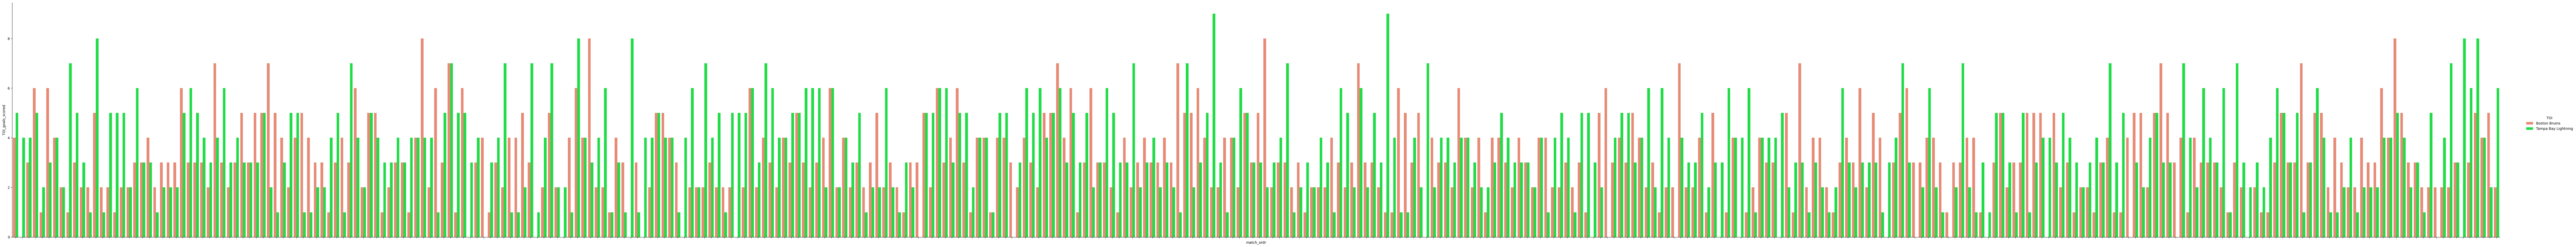

In [17]:
graphs = pd.concat([matches_team_1_graphs, matches_team_2_graphs], axis=0, ignore_index=False)
graphs['team'] = (len(matches_team_1_graphs)*(1,) + len(matches_team_2_graphs)*(2,))
graph_1 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='TOI', kind='bar', data=graphs, height=10, aspect=10, palette=["#FA7F63", "#00FC35"])
graph_1.set(xticklabels=[])
plt.show()

There were too many games played for the above graph to be informative. So we limit the analyzed data to last 30 games.

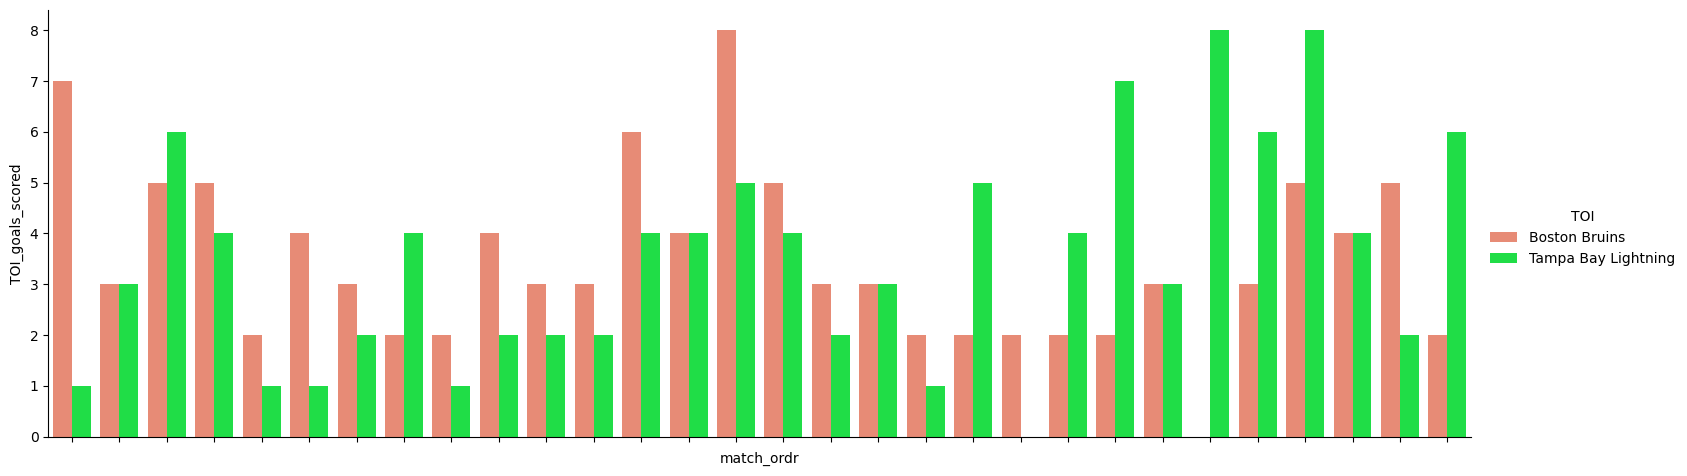

In [18]:
matches_team_1_graphs_30 = matches_team_1_graphs.tail(30).copy()
matches_team_2_graphs_30 = matches_team_2_graphs.tail(30).copy()
graphs_30_matches = pd.concat([matches_team_1_graphs_30, matches_team_2_graphs_30], axis=0, ignore_index=False)
graph_2 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='TOI', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_2.set(xticklabels=[])
plt.show()

### Recived Goals

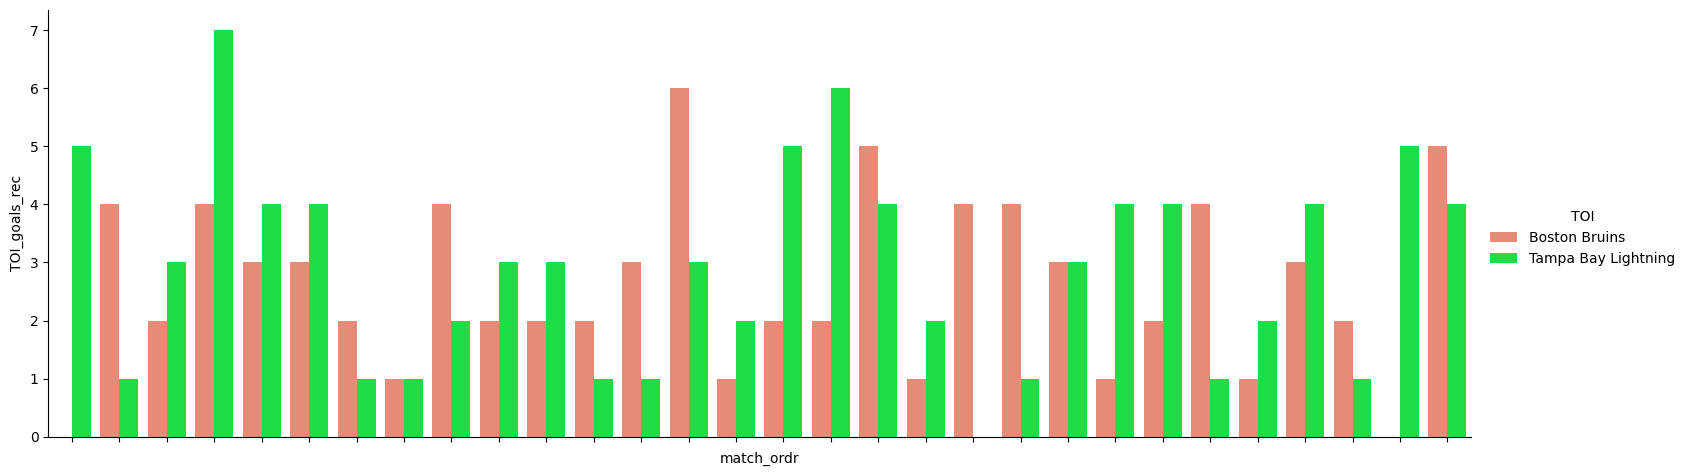

In [19]:
graph_3 = sns.catplot(x='match_ordr', y='TOI_goals_rec', hue='TOI', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_3.set(xticklabels=[])
plt.show()

### How teams did in last 30 matches

<function matplotlib.pyplot.show(close=None, block=None)>

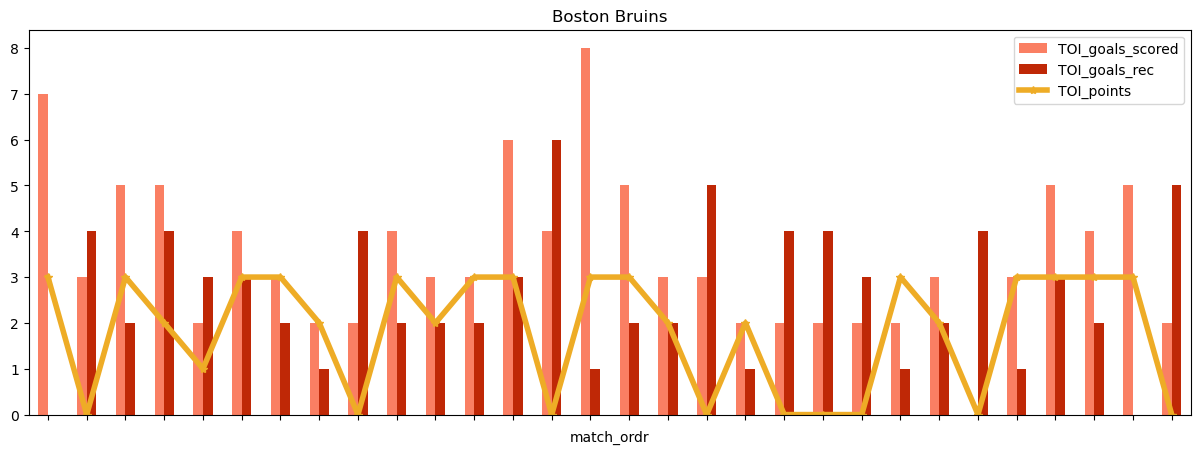

In [20]:
ax = matches_team_1_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#FA7F63", "#BF2806"],title=f'{team_1}')
matches_team_1_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#EEAC26"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

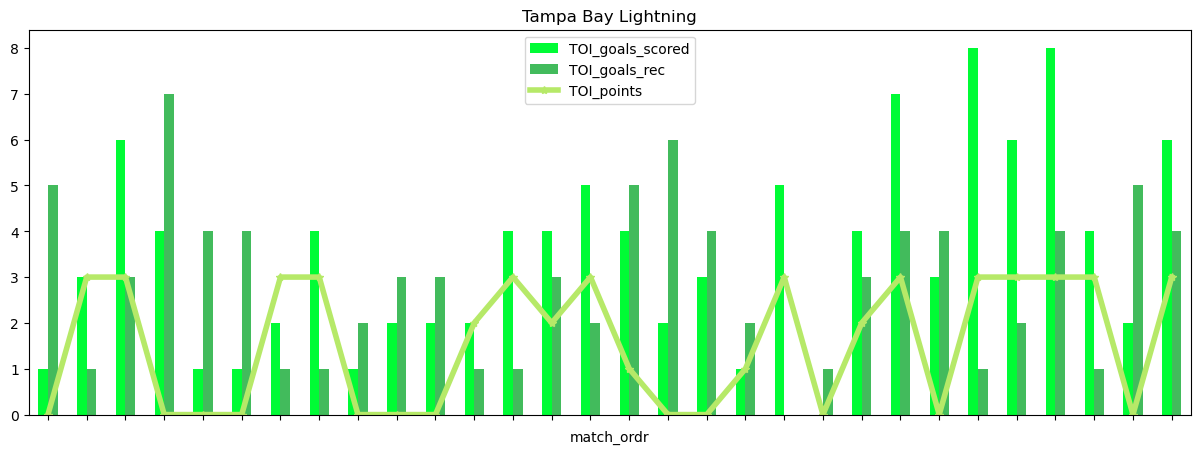

In [21]:
ax = matches_team_2_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#00FC35", "#42BB5C"],title=f'{team_2}')
matches_team_2_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#B6E968"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

## Model 1 - based on matches between 2 teams 

This is the most elementary model, most similar to random chance. We predict the outcome of the game based on who out of the two teams won the majority of the games those teams played together up to that point.
If the record is 50% to 50%, we predict the home team will won, due to the previously shown home advantage.

In [22]:
#first, we load the preprocessed datasets
matches_team_1_pre = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_pre = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')

In [23]:
model_1_mathes = matches_team_1_pre[matches_team_1_pre.other_team == team_2].copy()
model_1_mathes['match_ordr'] = range(1, len(model_1_mathes) + 1)
print(team_1, 'and', team_2, 'played', max(model_1_mathes.match_ordr), 'games together.')
model_1_mathes

Boston Bruins and Tampa Bay Lightning played 16 games together.


,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,0.0,1.0,3.0,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,1
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,3.0,0.0,3.0,3.0,0.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,2
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,0.0,1.0,3.0,4.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,3
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2017,4
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,5
145,/zapas/2648182,Boston Bruins,Tampa Bay Lightning,4,1,0,3.0,0.0,1.0,3.0,4.0,1.0,1.0,Tampa Bay Lightning,Boston Bruins,2018,6
157,/zapas/2648370,Tampa Bay Lightning,Boston Bruins,5,4,0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,7
163,/zapas/2648455,Boston Bruins,Tampa Bay Lightning,3,6,0,0.0,3.0,1.0,0.0,3.0,6.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,8
170,/zapas/2806474,Boston Bruins,Tampa Bay Lightning,3,4,1,1.0,2.0,1.0,1.0,3.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2019,9
196,/zapas/2806864,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2019,10


In [24]:
model_1_data = round((sum(model_1_mathes.TOI_result)/len(model_1_mathes.TOI_result))*100,3)
model_1_data_2ndteam = 100 - model_1_data
if model_1_data > 50:
    print(team_1,'is predicted to win the match. They won', model_1_data, '% of the previous games.')
    winner_model_1 = team_1
elif model_1_data < 50:
    print(team_2,'is predicted to win the match. They won', model_1_data_2ndteam, '% of the previous games.')
    winner_model_1 = team_2
elif model_1_data == 50:
    print(team_1,'is predicted to win the match. They won', model_1_data,
        '% of the previous games, and they are the home team, so they have home advantage.')
    winner_model_1 = team_1
else:
    print('This model cannot predict the winner as there were no games in the las 5 seasons where',
        team_1,'faced',team_2, '.')
    winner_model_1 = '-'

Boston Bruins is predicted to win the match. They won 50.0 % of the previous games, and they are the home team, so they have home advantage.


### Evaluation of the performance for the Model 1


In this section we evaluate the accuracy of the simple prediction process shown above. 

In [25]:
wins_before_match = []
matches_before_match = []
for x in model_1_mathes['match_ordr']:
    wins_before_match.append(model_1_mathes[(model_1_mathes['match_ordr'] < x)]['TOI_result'].sum())
    matches_before_match.append(model_1_mathes[(model_1_mathes['match_ordr'] < x)]['TOI_points'].count())

model_1_mathes['wins_before_match'] = wins_before_match
model_1_mathes['matches_before_match'] = matches_before_match
model_1_mathes.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr,wins_before_match,matches_before_match
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,0.0,1.0,3.0,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,1,0.0,0
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,3.0,0.0,3.0,3.0,0.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,2,1.0,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,0.0,1.0,3.0,4.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,3,2.0,2
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2017,4,3.0,3
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,5,3.0,4


In [26]:
# Is the home team predicted to win? Based on whether they won the majority of previous games.
# If unclear, the home team is predicted to win due to home advantage.
def predictions_score(row):
    if row['wins_before_match'] > (row['matches_before_match']/2):
        val = 1 #Team 1 is predicted to win.
    elif row['wins_before_match'] == (row['matches_before_match']/2) and row['team_home'] == row['TOI']:
        val = 1
    elif row['wins_before_match'] == (row['matches_before_match']/2) and row['team_home'] != row['TOI']:
        val = 0
    else:
        val = 0
    return val    
model_1_mathes['Prediction_score'] = model_1_mathes.apply(predictions_score, axis=1)
model_1_mathes.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr,wins_before_match,matches_before_match,Prediction_score
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,0.0,1.0,3.0,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,1,0.0,0,1
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,3.0,0.0,3.0,3.0,0.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,2,1.0,1,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,0.0,1.0,3.0,4.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,3,2.0,2,1
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2017,4,3.0,3,1
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,5,3.0,4,1


In [27]:
#Was the outcome correctly predicted?
def correctness_score(row):
    if row['TOI_result'] == row['Prediction_score']:
        val = 1
    else:
        val = 0
    return val
model_1_mathes['correct_score'] = model_1_mathes.apply(correctness_score, axis=1)

In [28]:
acc_model_1 = round((sum(model_1_mathes['correct_score'])/max((model_1_mathes['match_ordr']))*100),2)
if model_1_mathes.shape[0] == 0:
    print('Can not determine accuracy of the model as there was not enoug matches betwen',team_1, 'and', team_2)
else:
    print('Accuracy of model based on wins in previous duels is',acc_model_1,'%')

Accuracy of model based on wins in previous duels is 43.75 %


#### Now we get accuracy for all possible 2-team permutations and the average accuracy over all teams as well.

In [29]:
def get_accuracy(team1,team2):
    team_1_short = teams_dict[team1]
    matches_team_1_pre = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
    model_1_mathes = matches_team_1_pre[matches_team_1_pre.other_team == team2].copy()
    model_1_mathes['match_ordr'] = range(1, len(model_1_mathes) + 1)
    wins_before_match = []
    matches_before_match = []
    for x in model_1_mathes['match_ordr']:
        wins_before_match.append(model_1_mathes[(model_1_mathes['match_ordr'] < x)]['TOI_result'].sum())
        matches_before_match.append(model_1_mathes[(model_1_mathes['match_ordr'] < x)]['TOI_points'].count())

    model_1_mathes['wins_before_match'] = wins_before_match
    model_1_mathes['matches_before_match'] = matches_before_match

        
    model_1_mathes['Prediction_score'] = model_1_mathes.apply(predictions_score, axis=1)

    model_1_mathes['correct_score'] = model_1_mathes.apply(correctness_score, axis=1)
    
    accuracy_score = round((sum(model_1_mathes['correct_score'])/max((model_1_mathes['match_ordr'])))*100,3)
    return accuracy_score

In [30]:
#this are all possible ways that the teams can play
all_permutations = list(itertools.permutations(distinct_teams, 2))

In [31]:
model_1_accur = []
team1_accur = []
team2_accur = []
for couple in all_permutations:
    team1 = couple[0]
    team2 = couple[1]
    couple_accur = get_accuracy(team1, team2)
    team1_accur.append(team1)
    team2_accur.append(team2)
    model_1_accur.append(couple_accur)

Below is the accuracy for every possible duel achieved by this estimation method.

In [32]:
model_1_acc_df = pd.DataFrame({'team1':team1_accur, 'team2':team2_accur, 'accuracy':model_1_accur})
model_1_acc_df.head()

,team1,team2,accuracy
0,Anaheim Ducks,Arizona Coyotes,50.000
1,Anaheim Ducks,Boston Bruins,57.143
2,Anaheim Ducks,Buffalo Sabres,12.500
3,Anaheim Ducks,Calgary Flames,53.333
4,Anaheim Ducks,Carolina Hurricanes,50.000


Average accuracy by team

In [33]:
accuracies_df = model_1_acc_df.groupby('team1', as_index=False)['accuracy'].mean().round(3)
accuracies_dict_model_1 = dict(zip(accuracies_df['team1'], accuracies_df['accuracy']/100))
accuracies_df.columns = ['team', 'acc_model_1']

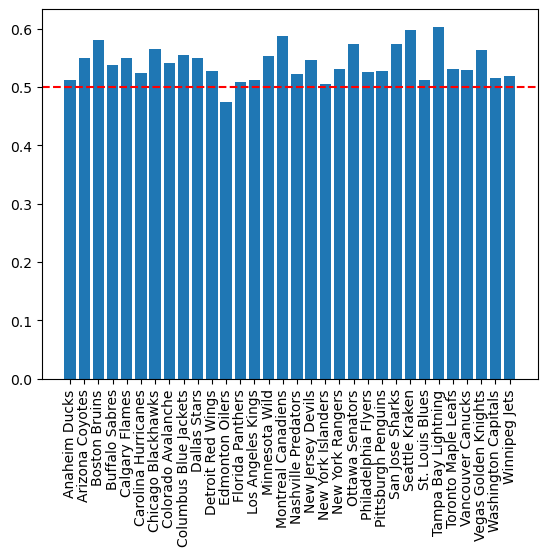

In [34]:
plt.bar(*zip(*accuracies_dict_model_1.items()))
plt.xticks(rotation='vertical')
plt.axhline(y= 0.5,color='red', linestyle ='dashed')
plt.show()

In [35]:
max_acc_model_1 = max(model_1_acc_df['accuracy'])
min_acc_model_1 = min(model_1_acc_df['accuracy'])
mean_acc_model_1 = round(mean(model_1_acc_df['accuracy']),3)
print(max_acc_model_1) # the maximum accuracy we were able to achieve with this model
print(min_acc_model_1) # the minimum accuracy we were achieved with this model
print(mean_acc_model_1) #the average accuracy we were able to achieve with this model

100.0
0.0
54.047


We try to investigate those that have suspiciously high or low accuracy

In [36]:
model_1_acc_df.loc[model_1_acc_df['accuracy'] == 100]

,team1,team2,accuracy
52,Arizona Coyotes,Pittsburgh Penguins,100.0
84,Boston Bruins,San Jose Sharks,100.0
85,Boston Bruins,Seattle Kraken,100.0
116,Buffalo Sabres,Seattle Kraken,100.0
140,Calgary Flames,New Jersey Devils,100.0
271,Columbus Blue Jackets,Seattle Kraken,100.0
488,Montreal Canadiens,Seattle Kraken,100.0
531,New Jersey Devils,Calgary Flames,100.0
674,Philadelphia Flyers,Seattle Kraken,100.0
683,Pittsburgh Penguins,Arizona Coyotes,100.0


In [37]:
model_1_acc_df.loc[model_1_acc_df['accuracy'] == 0]

,team1,team2,accuracy
209,Chicago Blackhawks,Seattle Kraken,0.0
581,New York Islanders,Seattle Kraken,0.0
705,Pittsburgh Penguins,Seattle Kraken,0.0
750,Seattle Kraken,Chicago Blackhawks,0.0
762,Seattle Kraken,New York Islanders,0.0
766,Seattle Kraken,Pittsburgh Penguins,0.0


Since Seattle Kraken only played last season it makes sense that the model performs poorly on them, since they did not play many matches

In [38]:
model_1_acc_df.loc[(model_1_acc_df['accuracy'] == 100) & (model_1_acc_df['team1'] != 'Seattle Kraken') & (model_1_acc_df['team2'] != 'Seattle Kraken')]

,team1,team2,accuracy
52,Arizona Coyotes,Pittsburgh Penguins,100.0
84,Boston Bruins,San Jose Sharks,100.0
140,Calgary Flames,New Jersey Devils,100.0
531,New Jersey Devils,Calgary Flames,100.0
683,Pittsburgh Penguins,Arizona Coyotes,100.0
715,San Jose Sharks,Boston Bruins,100.0


In [39]:
model_1_acc_dff = model_1_acc_df.loc[(model_1_acc_df['team1'] != 'Seattle Kraken') & (model_1_acc_df['team2'] != 'Seattle Kraken')]

In [40]:
print(max(model_1_acc_dff['accuracy']))
print(min(model_1_acc_dff['accuracy']))
mean(model_1_acc_dff['accuracy'])

100.0
12.5


53.67197634408602

All the duels that have accuracy zero, and many of those that have accuracy 100% have Seattle Kraken as one of the two teams. This makes sense, as this team only played one season, so we have less data points, and thus we are only able to make limited predictions. It seems to be more stable when we do not take Seattle Kraken into account (accuracies hitting the values 0 and 1 less often) and the minimum accuracy is then 12.5%; however the average accuracy is almost the same at about 54%.

## Model 2 - Logistic Regression

Now we make our predictions more complicated and we implement logistic regression model.

In [41]:
matches_team_1 = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_team_1.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526388,1.0,1.0,Boston Bruins,Pittsburgh Penguins,30.0,54.0,59.0,28.0,52.0,65.0
1,/zapas/2526415,0.0,1.0,Boston Bruins,Edmonton Oilers,30.0,54.0,59.0,20.0,53.0,69.0
2,/zapas/2526431,1.0,1.0,Boston Bruins,Tampa Bay Lightning,30.0,56.0,59.0,42.0,70.0,47.0
3,/zapas/2526450,1.0,0.0,Boston Bruins,Philadelphia Flyers,33.0,56.0,55.0,22.0,49.0,63.0
4,/zapas/2526468,0.0,0.0,Boston Bruins,Nashville Predators,33.0,53.0,53.0,37.0,64.0,58.0


We drop the unnecessary variables which will not be used for modelling.

In [42]:
#dropping unnecessary columns
matches_team_1 = matches_team_1.drop(columns=['game_id', 'TOI','other_team'])
matches_team_1.head()

,TOI_result,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,1.0,1.0,30.0,54.0,59.0,28.0,52.0,65.0
1,0.0,1.0,30.0,54.0,59.0,20.0,53.0,69.0
2,1.0,1.0,30.0,56.0,59.0,42.0,70.0,47.0
3,1.0,0.0,33.0,56.0,55.0,22.0,49.0,63.0
4,0.0,0.0,33.0,53.0,53.0,37.0,64.0,58.0


### This is the model we wish to estimate:

$$
\Large p = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7)}}
$$

Where:
* the dependent variable is TOI_result - win (1) or loose (0)

And the independent variables $x_1$ to $x_7$ are:
* *TOI_home*
* *TOI_points_tot*
* *TOI_goals_scored_tot*
* *TOI_goals_rec_tot*
* *other_team_points_tot*
* *other_team_goals_scored_tot*
* *other_team_goals_rec_tot*

Variable definitions to be found [here](#variables).

#### Defining the independent and dependent variables

In [43]:
#independent
x = matches_team_1.iloc[:, 1:].values
#dependent - the result
y = matches_team_1.iloc[:, 0].values

### Splitting into training and test set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [45]:
X_test[:5]

array([[ 1., 33., 55., 53., 35., 80., 72.],
       [ 0., 34., 67., 62., 23., 45., 61.],
       [ 0., 39., 62., 51., 20., 54., 67.],
       [ 1., 41., 68., 53., 20., 51., 64.],
       [ 0., 45., 61., 41., 34., 59., 54.]])

### Fitting the regression

In [46]:
reg = LogisticRegression(max_iter = 400)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

#### Loading the data for the second team

In [47]:
matches_team_2 = pd.read_csv(f'teams_final/{team_2_short}.csv')
matches_team_2.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526382,1.0,1.0,Tampa Bay Lightning,Chicago Blackhawks,45.0,80.0,52.0,30.0,61.0,53.0
1,/zapas/2526392,0.0,0.0,Tampa Bay Lightning,Washington Capitals,44.0,78.0,51.0,27.0,53.0,63.0
2,/zapas/2526407,0.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,44.0,75.0,49.0,25.0,52.0,67.0
3,/zapas/2526421,1.0,0.0,Tampa Bay Lightning,Buffalo Sabres,42.0,73.0,51.0,20.0,46.0,65.0
4,/zapas/2526431,0.0,0.0,Tampa Bay Lightning,Boston Bruins,42.0,70.0,47.0,30.0,56.0,59.0


### The final prediction of Model 2

We get the info about the last 20 games the teams played and input them into the estimated model

In [48]:
pred_team_1 = matches_team_1_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values

pred_team_2 = matches_team_2_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values

#let's fit the final value
values_to_fit = np.concatenate([np.array([1]),pred_team_1, pred_team_2]).reshape(1, -1)
final_pred = reg.predict(values_to_fit)

In [49]:
if final_pred[0] == 1:
    print('The team', team_1, "is predicted to win this game.")
    winner_lr = team_1
elif final_pred[0] == 0:
    print('The team', team_2, "is predicted to win this game.")
    winner_lr = team_2
else:
    print('An error occured along the way. Please try again.')
    winner_lr = '-'

The team Boston Bruins is predicted to win this game.


### The values to fit in the Logistic Regression 

<function matplotlib.pyplot.show(close=None, block=None)>

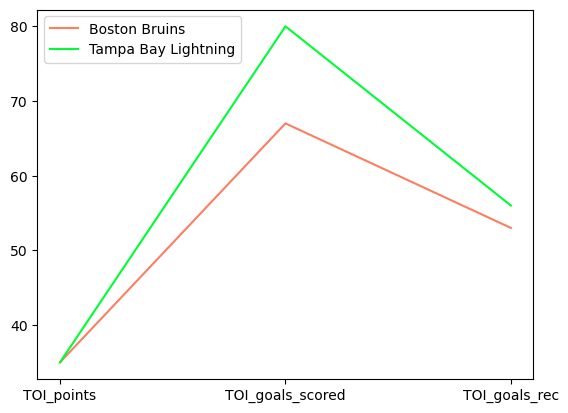

In [50]:
x_coordinates = ['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']
X_axis = np.arange(len(x_coordinates))
plt.plot(x_coordinates, pred_team_1,'#FA7F63',label=f'{team_1}') 
plt.plot(x_coordinates, pred_team_2,'#00FC35',label=f'{team_2}') 
plt.legend(loc="upper left")
plt.show

### Getting the accuracy and confusion matrix

In [51]:
#how well does the model perform?
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 3 24]
 [ 0 44]]


In [52]:
acc_lr = round(accuracy_score(y_test, y_pred)*100,3)
print("Accuracy :  \n", accuracy_score(y_test, y_pred))

Accuracy :  
 0.6619718309859155


### Evaluation of the performance for the Logistic Regression

#### Accuraccy of model 2 for every team

Now we calculate and visualize the accuracy of the logistic regression for every of the 32 teams, print out how many teams have lower accuracy than 50% (random chance), and we also compute the average accuracy over all teams.

In [53]:
#How accurate is the model for individual teams?
accuracies_lr = []
accuracies_dict_lr = {}
for one_team_acc in distinct_teams:
    one_team_short_acc = teams_dict[one_team_acc]
    matches_one_team_acc = pd.read_csv(f'teams_final/{one_team_short_acc}.csv')
    matches_one_team_acc = matches_one_team_acc.drop(columns=['game_id', 'TOI','other_team'])
    x_acc = matches_one_team_acc.iloc[:, 1:].values
    y_acc = matches_one_team_acc.iloc[:, 0].values
    X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(x_acc, y_acc, test_size = 0.20, random_state = 0)

    reg_acc = LogisticRegression(max_iter = 400)
    reg_acc.fit(X_train_acc, y_train_acc)
    y_pred_acc = reg_acc.predict(X_test_acc)
    score_acc = accuracy_score(y_test_acc, y_pred_acc)
    accuracies_lr.append(score_acc)
    accuracies_dict_lr[one_team_acc] = round(score_acc,3)
    

print(accuracies_dict_lr)
print(sum(acc < 0.5 for acc in accuracies_lr), "teams have lower accuracy than 50%")
#4 teams out of 32 have lower then 0.5 accuracy

{'Anaheim Ducks': 0.577, 'Arizona Coyotes': 0.471, 'Boston Bruins': 0.662, 'Buffalo Sabres': 0.614, 'Calgary Flames': 0.535, 'Carolina Hurricanes': 0.486, 'Chicago Blackhawks': 0.535, 'Colorado Avalanche': 0.577, 'Columbus Blue Jackets': 0.507, 'Dallas Stars': 0.557, 'Detroit Red Wings': 0.634, 'Edmonton Oilers': 0.535, 'Florida Panthers': 0.549, 'Los Angeles Kings': 0.535, 'Minnesota Wild': 0.557, 'Montreal Canadiens': 0.521, 'Nashville Predators': 0.557, 'New Jersey Devils': 0.686, 'New York Islanders': 0.529, 'New York Rangers': 0.443, 'Ottawa Senators': 0.62, 'Philadelphia Flyers': 0.486, 'Pittsburgh Penguins': 0.543, 'San Jose Sharks': 0.577, 'Seattle Kraken': 0.692, 'St. Louis Blues': 0.507, 'Tampa Bay Lightning': 0.634, 'Toronto Maple Leafs': 0.535, 'Vancouver Canucks': 0.5, 'Vegas Golden Knights': 0.549, 'Washington Capitals': 0.6, 'Winnipeg Jets': 0.521}
4 teams have lower accuracy than 50%


In [54]:
max_acc_lr = round(max(accuracies_lr)*100,3)
min_acc_lr = round(min(accuracies_lr)*100,3)
mean_acc_lr = round(mean(accuracies_lr)*100,3)
print(max_acc_lr) # the maximum accuracy we were able to achieve with this model
print(min_acc_lr) # the minimum accuracy we achieved with this model
print(mean_acc_lr) # the average accuracy we were able to achieve with this model

69.231
44.286
55.73


In [55]:
accuracies_lr_df = [round(i * 100,3) for i in accuracies_lr]
accuracies_df['acc_log_reg'] = accuracies_lr_df
accuracies_df.head(10)

,team,acc_model_1,acc_log_reg
0,Anaheim Ducks,51.138,57.746
1,Arizona Coyotes,54.907,47.143
2,Boston Bruins,58.053,66.197
3,Buffalo Sabres,53.832,61.429
4,Calgary Flames,54.909,53.521
5,Carolina Hurricanes,52.326,48.571
6,Chicago Blackhawks,56.406,53.521
7,Colorado Avalanche,54.095,57.746
8,Columbus Blue Jackets,55.386,50.704
9,Dallas Stars,55.025,55.714


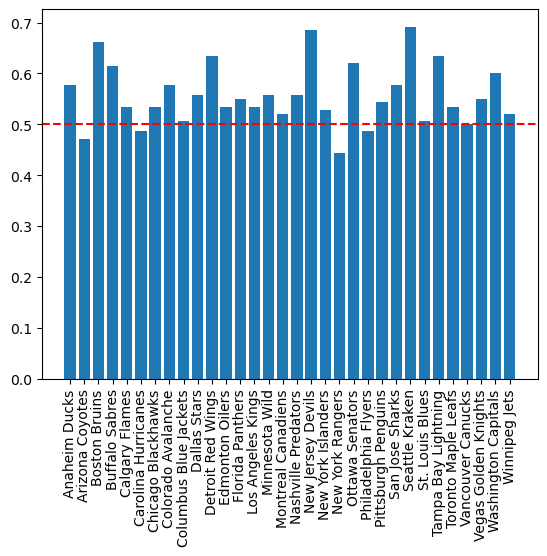

In [56]:
plt.bar(*zip(*accuracies_dict_lr.items()))
plt.xticks(rotation='vertical')
plt.axhline(y= 0.5,color='red', linestyle ='dashed')
plt.show()

And how accurate is the model on average?

<b>We can see that the model performs relatively good. Being 55.7% accurate on average, and only 4 teams out of 32 performing worse than a random chance. However, there might be a better solution. Let's try another model.</b>

The second model has similary accuracy, on average, as the firts estimation method. Overall, we would recommend the logistic regression over the first estimation method or random chance, as it seems to be performing with consistent results and more reliably.

## Model 3 - Neural Network

And finally we implement the last estimation procedure, the neural network. We consider this method suitable for our data, since neural networks can model complex, non-linear relationships with no predefined formula, and we cannot be sure about the form of the relationship we are dealing with; moreover, we can make fewer assumptions about our data, for example there is no assumption about collinearity.

### Neural Network using tensorflow

Due to the nature of neural networks and the respective activation functions, we first scale the data. Then we split them into training, validation and testing with ratio 60:20:20.

We build a 7-4-2 Neural network (the number of neurons in the hidden layer was chosen by observing the performance of several viable choices). Based on commonly used activation functions in the literature, the rectifier function was used for the hidden layer and the sigmoid function was used for the output layer. The rest of the parameters were tuned based on performance.

In [57]:
scaler_nn = StandardScaler()

x_nn = scaler_nn.fit_transform(x[:,1:])
x_nn = np.insert(x_nn,0,x[:,0],axis=1)
y_nn = keras.utils.to_categorical(1-y)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(x_nn, y_nn, test_size = 0.2, random_state = 0)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn, y_train_nn, test_size=0.25, random_state=0)


model = Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
model.add(layers.Dense(2, activation='sigmoid'))
    
opt = SGD(learning_rate=0.01)
    
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32
steps_per_epoch = len(X_train_nn)//batch_size
    
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 15,
                                        restore_best_weights = True, min_delta = 0)
    
model.fit(X_train_nn, y_train_nn, epochs=150, batch_size=batch_size, validation_data=(X_val_nn, y_val_nn),
          steps_per_epoch=steps_per_epoch, callbacks =[earlystopping], verbose = 0)

loss, score = model.evaluate(X_test_nn, y_test_nn, verbose=0)
acc_nn = round(score*100, 3)
print('The accuracy of this Neural Network is', acc_nn)

Metal device set to: Apple M1


2022-08-30 13:05:13.057763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-30 13:05:13.057874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-30 13:05:13.136809: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-30 13:05:13.370037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:13.547318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The accuracy of this Neural Network is 61.972


In [58]:
values_to_fit_nn = scaler_nn.transform(values_to_fit[:,1:]) #we have to scale the values to fit
values_to_fit_nn = np.insert(values_to_fit_nn,0,1,axis=1)

In [59]:
prediction_nn = (model.predict(values_to_fit_nn, verbose = 0) > 0.5).astype(int)[0,0]
if prediction_nn == 1:
    print('The team', team_1, "is predicted to win this game.")
    winner_nn = team_1
elif prediction_nn == 0:
    print('The team', team_2, "is predicted to win this game.")
    winner_nn = team_2
else:
    print('An error occured along the way. Please try again.')
    winner_nn = '-'

The team Boston Bruins is predicted to win this game.


2022-08-30 13:05:20.279363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Simple visualisation of the network

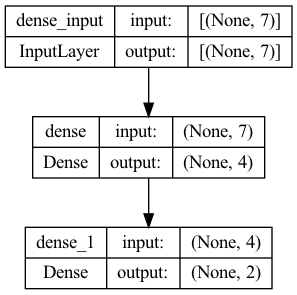

In [60]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Evaluation of the performance for the neural network

In [61]:
accuracies_nn = []
accuracies_dict_nn = {}
for one_team_nn in distinct_teams:
    one_team_short_nn = teams_dict[one_team_nn]
    matches_one_team_nn = pd.read_csv(f'teams_final/{one_team_short_nn}.csv')
    matches_one_team_nn = matches_one_team_nn.drop(columns=['game_id', 'TOI','other_team'])
    x_nn = matches_one_team_nn.iloc[:, 1:].values
    y_nn = matches_one_team_nn.iloc[:, 0].values
    y_nn = keras.utils.to_categorical(1-y_nn)
    
    scaler_nn = StandardScaler()
    x_nn_norm = scaler_nn.fit_transform(x_nn[:,1:])
    x_nn_norm = np.insert(x_nn_norm,0,x_nn[:,0],axis=1)
    
    
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(x_nn_norm, y_nn, test_size = 0.2, random_state = 0)
    
    X_train_nn, X_vald_nn, y_train_nn, y_vald_nn = train_test_split(X_train_nn, y_train_nn, test_size=0.25, random_state=0)
    
    model = Sequential()
    model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    opt = SGD(learning_rate=0.01)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    batch_size = 32
    steps_per_epoch = len(X_train_nn)//batch_size
    
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True, min_delta = 0)
    
    model.fit(X_train_nn, y_train_nn, epochs=150, batch_size=batch_size, validation_data=(X_vald_nn, y_vald_nn),
             steps_per_epoch=steps_per_epoch, callbacks =[earlystopping], verbose = 0)

    loss, score_nn = model.evaluate(X_test_nn, y_test_nn, verbose=0)
    
    accuracies_nn.append(score_nn)
    accuracies_dict_nn[one_team_nn] = round(score_nn,3)

2022-08-30 13:05:20.662282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:20.798807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:24.117590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:24.254254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:29.579423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:29.717930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:05:35.725503: I tensorflow/core/grappler/optimizers/cust

2022-08-30 13:07:48.054521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:07:48.224084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:07:54.270727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:07:54.440355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:08:00.535211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:08:00.706744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 13:08:06.275588: I tensorflow/core/grappler/optimizers/cust

In [62]:
print(accuracies_dict_nn)
print(sum(acc < 0.5 for acc in accuracies_nn), "team/s have lower accuracy than 50%")

{'Anaheim Ducks': 0.606, 'Arizona Coyotes': 0.471, 'Boston Bruins': 0.704, 'Buffalo Sabres': 0.629, 'Calgary Flames': 0.563, 'Carolina Hurricanes': 0.586, 'Chicago Blackhawks': 0.577, 'Colorado Avalanche': 0.549, 'Columbus Blue Jackets': 0.563, 'Dallas Stars': 0.571, 'Detroit Red Wings': 0.592, 'Edmonton Oilers': 0.592, 'Florida Panthers': 0.592, 'Los Angeles Kings': 0.577, 'Minnesota Wild': 0.543, 'Montreal Canadiens': 0.592, 'Nashville Predators': 0.5, 'New Jersey Devils': 0.629, 'New York Islanders': 0.643, 'New York Rangers': 0.529, 'Ottawa Senators': 0.563, 'Philadelphia Flyers': 0.6, 'Pittsburgh Penguins': 0.529, 'San Jose Sharks': 0.563, 'Seattle Kraken': 0.538, 'St. Louis Blues': 0.563, 'Tampa Bay Lightning': 0.662, 'Toronto Maple Leafs': 0.563, 'Vancouver Canucks': 0.543, 'Vegas Golden Knights': 0.507, 'Washington Capitals': 0.614, 'Winnipeg Jets': 0.577}
1 team/s have lower accuracy than 50%


In [63]:
max_acc_nn = round(max(accuracies_nn)*100,3)
min_acc_nn = round(min(accuracies_nn)*100,3)
mean_acc_nn = round(mean(accuracies_nn)*100,3)
print(max_acc_nn) # the maximum accuracy we were able to achieve with this model
print(min_acc_nn) # the minimum accuracy we achieved with this model
print(mean_acc_nn) # the average accuracy we were able to achieve with this model

70.423
47.143
57.598


In [64]:
accuracies_nn_df = [round(i * 100,3) for i in accuracies_nn]
accuracies_df['acc_nn'] = accuracies_nn_df
accuracies_df.head(10)

,team,acc_model_1,acc_log_reg,acc_nn
0,Anaheim Ducks,51.138,57.746,60.563
1,Arizona Coyotes,54.907,47.143,47.143
2,Boston Bruins,58.053,66.197,70.423
3,Buffalo Sabres,53.832,61.429,62.857
4,Calgary Flames,54.909,53.521,56.338
5,Carolina Hurricanes,52.326,48.571,58.571
6,Chicago Blackhawks,56.406,53.521,57.746
7,Colorado Avalanche,54.095,57.746,54.930
8,Columbus Blue Jackets,55.386,50.704,56.338
9,Dallas Stars,55.025,55.714,57.143


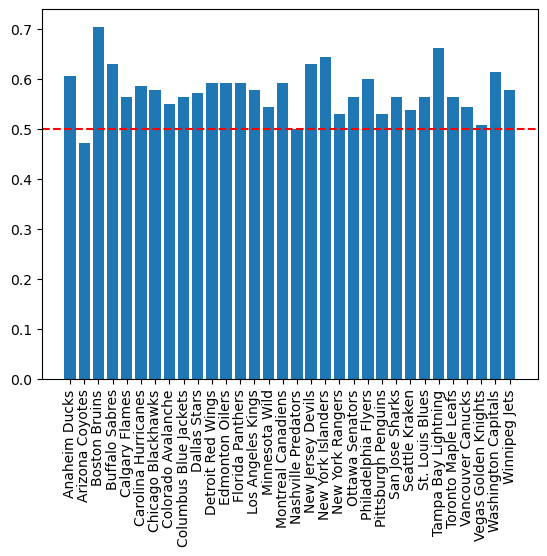

In [65]:
plt.bar(*zip(*accuracies_dict_nn.items()))
plt.xticks(rotation='vertical')
plt.axhline(y= 0.5,color='red', linestyle ='dashed')
plt.show()

## Comparison of the 3 models and their performance

The summary statistics of our models and their preictions

All accuracies are in %

In [66]:
summary_df = pd.DataFrame(columns=['model'])
summary_df['model'] = ['Model 1', 'Logistic Regression', 'Neural Network']
summary_df['predicted winner'] = [winner_model_1, winner_lr, winner_nn]
summary_df['accuracy'] = [acc_model_1, acc_lr, acc_nn]
summary_df['mean_accuracy'] = [mean_acc_model_1, mean_acc_lr, mean_acc_nn]
summary_df['min_accuracy'] = [min_acc_model_1, min_acc_lr, min_acc_nn]
summary_df['max_accuracy'] = [max_acc_model_1, max_acc_lr, max_acc_nn]

In [67]:
summary_df

,model,predicted winner,accuracy,mean_accuracy,min_accuracy,max_accuracy
0,Model 1,Boston Bruins,43.750,54.047,0.000,100.000
1,Logistic Regression,Boston Bruins,66.197,55.730,44.286,69.231
2,Neural Network,Boston Bruins,61.972,57.598,47.143,70.423


In [68]:
accuracies_df_sorted_plot = accuracies_df.sort_values(by=['acc_nn'], ascending=False)
color_list = ['blue', 'red', 'green']
plt.rcParams["figure.figsize"] = (20,5)

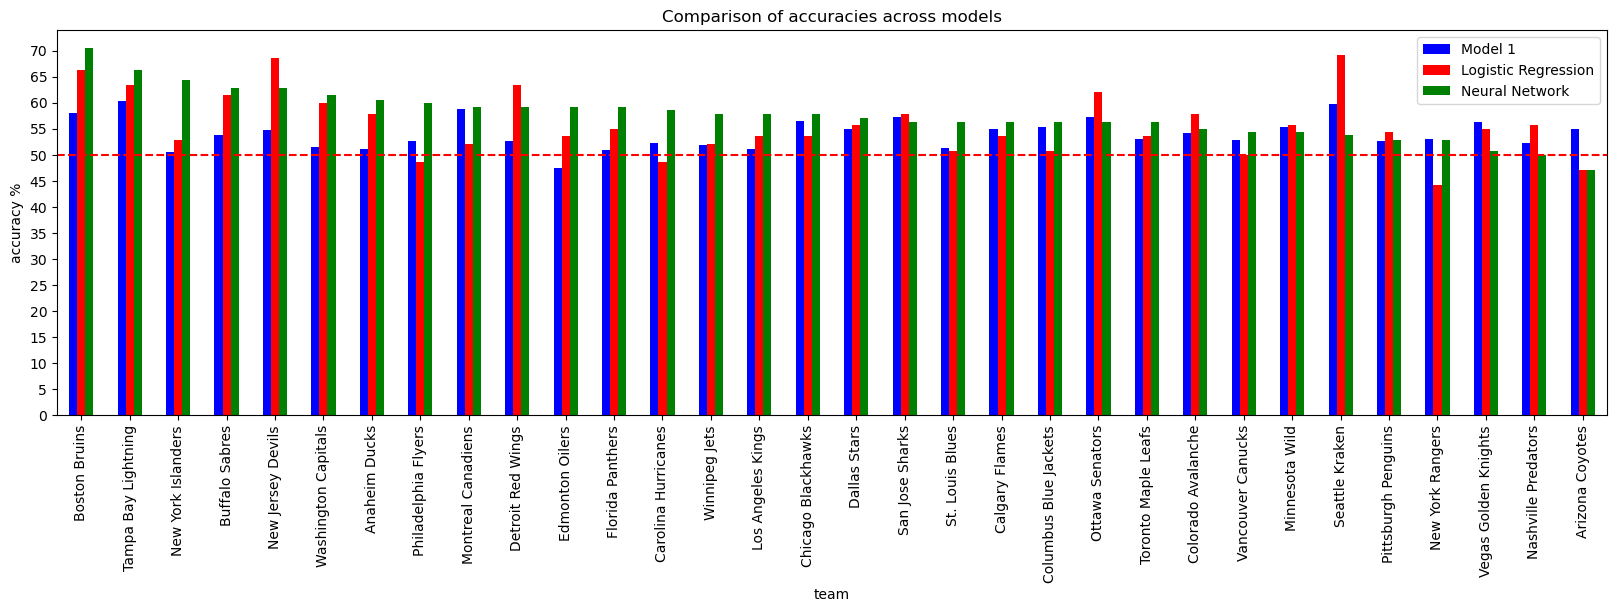

In [69]:
accuracies_df_sorted_plot.plot(kind='bar', color=color_list, x = 'team', y = ['acc_model_1', 'acc_log_reg','acc_nn'])
plt.title('Comparison of accuracies across models')
plt.legend(["Model 1", "Logistic Regression", "Neural Network"])
plt.ylabel('accuracy %')
plt.yticks(np.arange(0,75,5))
plt.axhline(y= 50,color='red', linestyle ='dashed')
plt.show()

In [70]:
accuracies_df['average_acc'] = accuracies_df[['acc_model_1', 'acc_log_reg','acc_nn']].mean(axis=1).round(3)
accuracies_df.head()

,team,acc_model_1,acc_log_reg,acc_nn,average_acc
0,Anaheim Ducks,51.138,57.746,60.563,56.482
1,Arizona Coyotes,54.907,47.143,47.143,49.731
2,Boston Bruins,58.053,66.197,70.423,64.891
3,Buffalo Sabres,53.832,61.429,62.857,59.373
4,Calgary Flames,54.909,53.521,56.338,54.923


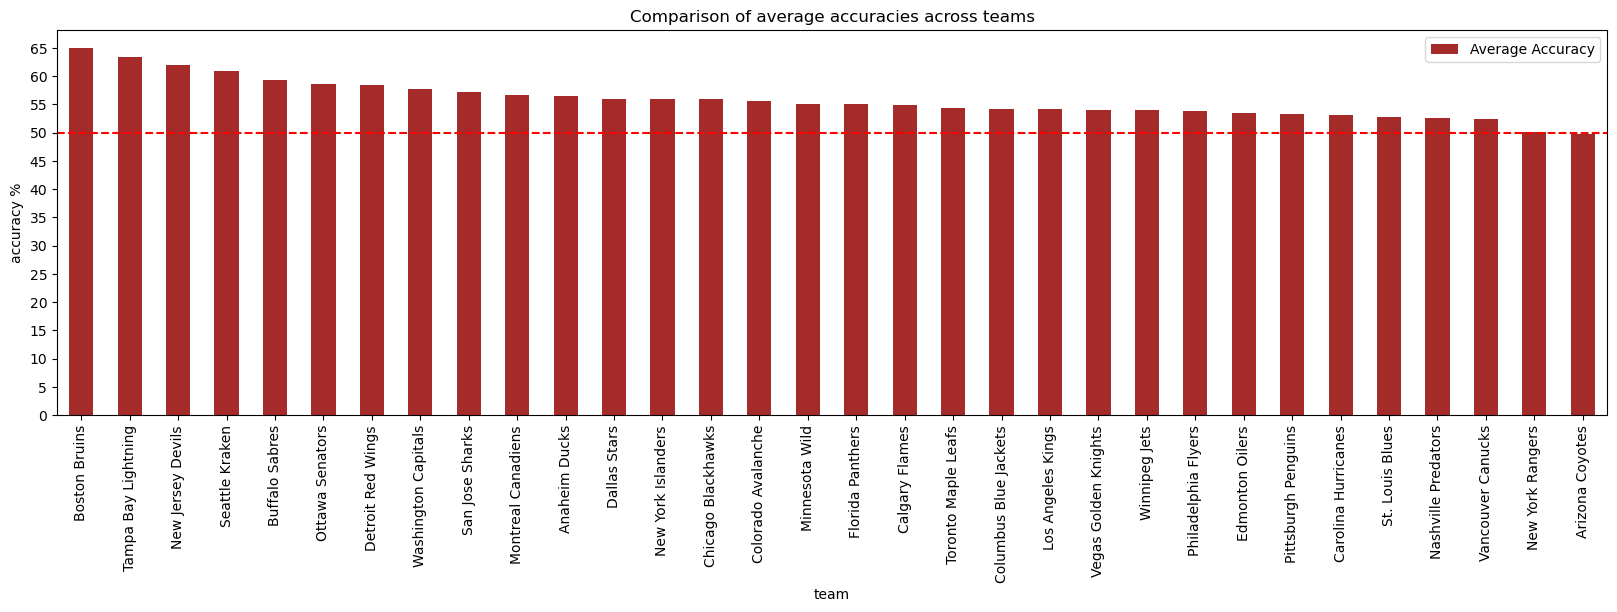

In [71]:
accuracies_df_sorted = accuracies_df.sort_values(by=['average_acc'], ascending=False)
accuracies_df_sorted.plot(kind='bar', color = 'brown', x = 'team', y = 'average_acc')
plt.title('Comparison of average accuracies across teams')
plt.ylabel('accuracy %')
plt.yticks(np.arange(0,70,5))
plt.legend(["Average Accuracy"])
plt.axhline(y= 50,color='red', linestyle ='dashed')
plt.show()

And which model performs better for what team? Logistic Regression or Neural Network?

In [72]:
accuracies_df_index = accuracies_df.set_index('team')
prefered_model = pd.DataFrame(columns=['Team', 'Prefered model', 'Accuracy'])
for team in distinct_teams:
    if accuracies_df_index.acc_log_reg[team] > accuracies_df_index.acc_nn[team]:
        model_pref = 'Logistic Regression'
        acc_pref = accuracies_df_index.acc_log_reg[team]
    elif accuracies_df_index.acc_log_reg[team] < accuracies_df_index.acc_nn[team]:
        model_pref = 'Neural Network'
        acc_pref = accuracies_df_index.acc_nn[team]
    else:
        model_pref = 'None'
        acc_pref = accuracies_df_index.acc_nn[team]
    df_aux = pd.DataFrame({'Team': [team],
                    'Prefered model' : [model_pref],
                    'Accuracy' : [acc_pref]})
    prefered_model = pd.concat([prefered_model, df_aux], ignore_index = True, axis = 0)

In [73]:
prefered_model.head()

,Team,Prefered model,Accuracy
0,Anaheim Ducks,Neural Network,60.563
1,Arizona Coyotes,None,47.143
2,Boston Bruins,Neural Network,70.423
3,Buffalo Sabres,Neural Network,62.857
4,Calgary Flames,Neural Network,56.338


In [74]:
pref_nn = len(prefered_model.loc[prefered_model['Prefered model'] == 'Neural Network',:])
print('Neural Network has higher accuracy than Logistic Reg. for', pref_nn, 'teams.')

Neural Network has higher accuracy than Logistic Reg. for 21 teams.


In [75]:
pref_lr = len(prefered_model.loc[prefered_model['Prefered model'] == 'Logistic Regression',:])
print('Logistic Regression has higher accuracy than Neural Network for', pref_lr, 'teams.')

Logistic Regression has higher accuracy than Neural Network for 10 teams.


# Conclusion

The [General Data Analytics](#General_da) revealed that there is at least slight home advantage in the last five seasons, for all teams but 2 (Calgary Flames and Washington Capitals). The highest home advantage was found for the team Seattle Kraken, with more then 59%. In addition, the home advantage appears stable over the analyzed seasons; however it was marginally higher in the 2017/18 season when compared to the other years (more that 56% compared to just above 53%).

The game result estimation of course differs based on what teams the user chooses. First, one can get an idea about the two teams chosen in the [Data Analytics about the two teams](#2team_da) section. Then we move on to predictions. The three methods (or at least the 2 formal models) generally predict the same winner. While the first estimation method (the one based on who won the most previous duels) seems to be the most unstable, having very low, or even zero, accuracy for some duels. This can be due to the fact that this method is the most similar to just guessing the winner - we use some data to back up our estimation, but there is no real modelling of data involved, thus it can fail more often. Overall, with our data, the Neural Network tends to outperform the Logistic Regression which tends to be superior to the first method.


We can also observe that for some teams the models perform much better than for others. This can be due to some noise in the data, or simply that the models are not as suitable for some of the teams. Although we tuned the model parameters and for some teams the models perform well and comparably to models used in published papers on similar topics (see eg. Prasetio, 2016), there seems to be more to the story for some other teams. There are several areas that could be explored in the future: it might be that other variables, or other functional form of our variables could be (also) important, or that the parameters of the models need further adjusting.

Nonetheless, comparing the three estimation methods provides insightful information about the teams and methods themselves. Due to the nature of the neural network, the results might differ a bit each time it is build. However, it seems that has higher accuracy than logistic regression for about 2/3 of the teams each time. Therefore, we conclude, that it is the most suitable method out of the three.

(Citation: Prasetio, D., 2016, August. Predicting football match results with logistic regression. In 2016 International Conference On Advanced Informatics: Concepts, Theory And Application (ICAICTA) (pp. 1-5). IEEE.)